In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Primera parte
1. Abrimos imagen en escala de grises

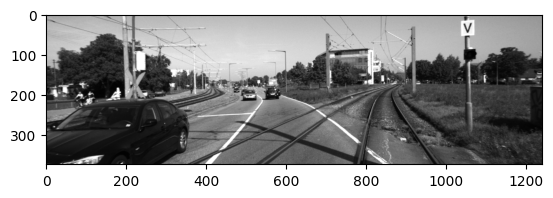

In [4]:
image = cv2.imread('../../IMAGES/DATASET_IMAGES/KITII/testing/um_000004.png', 0)
img = np.copy(image)
wid, hght = img.shape
plt.imshow(image,  cmap='gray')

2. Aplicamos un suavizado gaussiano a la imagen

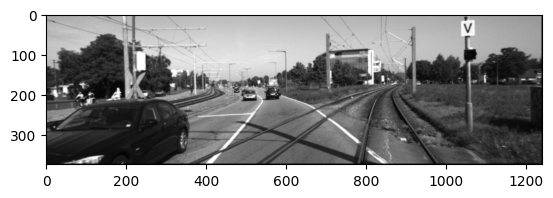

In [5]:
def suavizado(img):
    gauss = [
        [1, 4, 6, 4, 1],
        [4, 16, 24, 16, 4],
        [6, 24, 36, 24, 6],
        [4, 16, 24, 16, 4],
        [1, 4, 6, 4, 1]
    ]

    # Dividir el kernel entre la suma (256)
    gauss2 = np.divide(gauss, 256)

    forma = np.shape(img)
    gaussiano2 = np.zeros(forma)

    # Suavizado gaussiano
    for x in list(range(1, forma[0]-1)):
        for y in list(range(1, forma[1]-1)):
            suma = 0
            for i in list(range(-1, 2)):
                for j in list(range(-1, 2)):
                    suma = img[x-i, y-j] * gauss2[i+1, j+1]+suma
            gaussiano2[x, y] = suma
    maxs = np.max(gaussiano2)
    gaussiano2 = gaussiano2*255/maxs
    gaussiano2 = gaussiano2.astype(np.uint8)
    return gaussiano2

# Crear kernel gaussiano
gaussian = suavizado(img)
plt.imshow(gaussian, cmap='gray')

3. Hacemos las derivadas de la imagen.

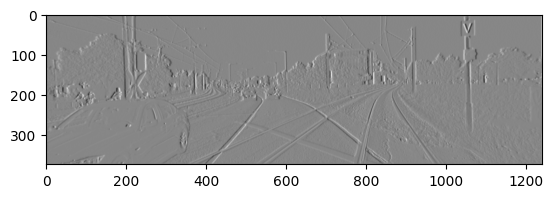

In [6]:
kernel_sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_sobel_y = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])

def convolucion(img, kernel):

    forma = np.shape(img)
    base2 = np.zeros(forma)

    for x in list(range(1, forma[0]-1)):
        for y in list(range(1, forma[1]-1)):
            suma = 0
            for i in list(range(-1, 2)):
                for j in list(range(-1, 2)):
                    suma = img[x-i, y-j] * kernel[i+1, j+1]+suma
            base2[x, y] = suma
    #maxs = np.max(base2)
    #base2 = base2*255/maxs
    #base2 = base2.astype(np.uint8)
    return base2

sobel_x = convolucion(gaussian, kernel_sobel_x)
plt.imshow(sobel_x, cmap='gray')

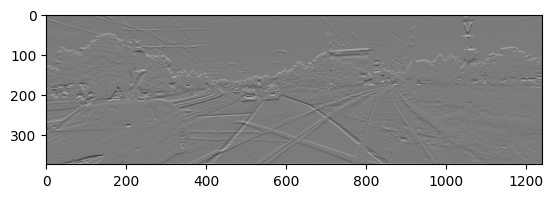

In [7]:
sobel_y = convolucion(gaussian, kernel_sobel_y)
plt.imshow(sobel_y, cmap='gray')

4. Aplicamos algoritmo de Canny para detectar bordes

In [19]:
def canny(img, low_threshold, high_threshold, sobel_x, sobel_y):
    # Paso 1: Suavizado de la imagen
    image = gaussian

    # Paso 2: Cálculo de gradientes (Sobel)
    gradient_x = sobel_x
    gradient_y = sobel_y

    # Magnitud del gradiente y dirección
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * (180 / np.pi)

    # Paso 3: Supresión de no máximos
    gradient_magnitude_suppressed = np.copy(gradient_magnitude)

    for i in range(1, wid - 1):
        for j in range(1, hght - 1):
            angle = gradient_direction[i, j]
            mag = gradient_magnitude_suppressed[i, j]
            
            # Definir los índices de los píxeles vecinos
            i_n, j_n = i, j

            if (0 <= angle < 22.5) or (157.5 <= angle <= 180) or (-22.5 <= angle < 0) or (-180 <= angle < -157.5):
                j_n += 1
            elif (22.5 <= angle < 67.5) or (-157.5 <= angle < -112.5):
                i_n -= 1
                j_n += 1
            elif (67.5 <= angle < 112.5) or (-112.5 <= angle < -67.5):
                i_n -= 1
            elif (112.5 <= angle < 157.5) or (-67.5 <= angle < -22.5):
                i_n -= 1
                j_n -= 1

            # Comprobar si el píxel actual es un máximo local
            if mag < gradient_magnitude_suppressed[i_n:i_n+2, j_n:j_n+2].max():
                gradient_magnitude_suppressed[i, j] = 0

    # Umbralización (Hysteresis)
    edges = np.zeros((wid, hght))
    strong_edge_i, strong_edge_j = np.where(gradient_magnitude_suppressed > high_threshold)
    weak_edge_i, weak_edge_j = np.where((gradient_magnitude_suppressed >= low_threshold) & (gradient_magnitude_suppressed <= high_threshold))

    edges[strong_edge_i, strong_edge_j] = 255

    for idx in range(len(weak_edge_i)):
        i, j = weak_edge_i[idx], weak_edge_j[idx]
        if np.any(edges[i-1:i+2, j-1:j+2] == 255):
            edges[i, j] = 255

    return edges.astype(np.uint8)

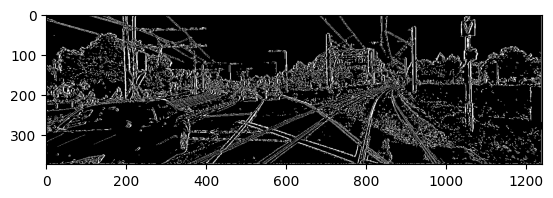

In [20]:
img_canny = canny(img, 50, 60, sobel_x, sobel_y)
plt.imshow(img_canny, cmap='gray')

# Algoritmo de Hough

1. Redimensionamos la imagen con los bordes detectados

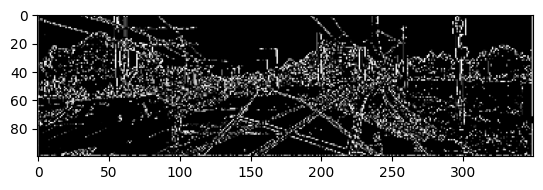

In [11]:
img_canny = cv2.resize(img_canny,(350, 100), interpolation = cv2.INTER_LINEAR)
plt.imshow(img_canny, cmap='gray')

In [12]:
def hough_transform(image):
    hght, wid = image.shape

    # Maximo valor de distancia (rho)
    max_rho = int(np.sqrt(hght**2 + wid**2))

    # Ángulos en grados convertidos a radianes
    theta_range = np.deg2rad(np.arange(-90, 90))

    # Rango de rho
    rho_range = np.arange(-max_rho, max_rho + 1)

    # Matriz acumulativa H de tamaño de las rho*thetas
    H = np.zeros((len(rho_range), len(theta_range)), dtype=np.uint64)

    # Encontrar los pixeles que son 0 en la imagen
    white_pixels = np.argwhere(image > 0)
    #edge_pixels = np.argwhere(img > 0)

    # Transformada de Hough
    for y, x in white_pixels:
        for theta_index, theta in enumerate(theta_range):
            # Calcular rho
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_index = np.argmin(np.abs(rho_range - rho))
            #rho_index = np.argmin(np.abs(rho + rho_range/2))
            H[rho_index, theta_index] += 1

    return H, theta_range, rho_range


In [13]:
def hough_line_peaks(H, thetas, rhos, threshold=0.5):
    # Encontrar los picos en la matriz acumuladora H
    peak_values = np.max(H) * threshold
    peak_indices = np.argwhere(H > peak_values)
    
    # Obtener los valores de rho y theta de los picos
    rho_values = [rhos[idx[0]] for idx in peak_indices]
    theta_values = [thetas[idx[1]] for idx in peak_indices]
    
    return rho_values, theta_values

2. Aplicamos Hough a la imagen.

In [14]:
H, thetas, rhos = hough_transform(img_canny)

3. Mostramos las líneas detectadas, sobre la imagen.

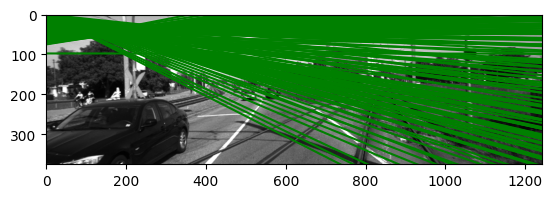

In [16]:
# Encontrar y dibujar las líneas detectadas en la imagen original
rho_values, theta_values = hough_line_peaks(H, thetas, rhos)
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

for rho, theta in zip(rho_values, theta_values):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + (1500) * (-b))
    y1 = int(y0 + (1500) * (a))
    x2 = int(x0 - (1500) * (-b))
    y2 = int(y0 - (1500) * (a))
    ax.plot([x1, x2], [y1, y2], 'g')

ax.set_xlim([0, img.shape[1]])
ax.set_ylim([img.shape[0], 0])
plt.show()

4. Mostramos el espacio de Hough, utilizando el logartirmo.

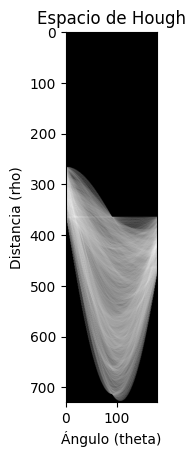

In [17]:
# Crear una imagen del espacio de Hough
plt.imshow(np.log(1 + H), cmap='gray')
plt.title('Espacio de Hough')
plt.xlabel('Ángulo (theta)')
plt.ylabel('Distancia (rho)')
plt.show()

5. Repetimos el procedimiento con las demás imagenes.

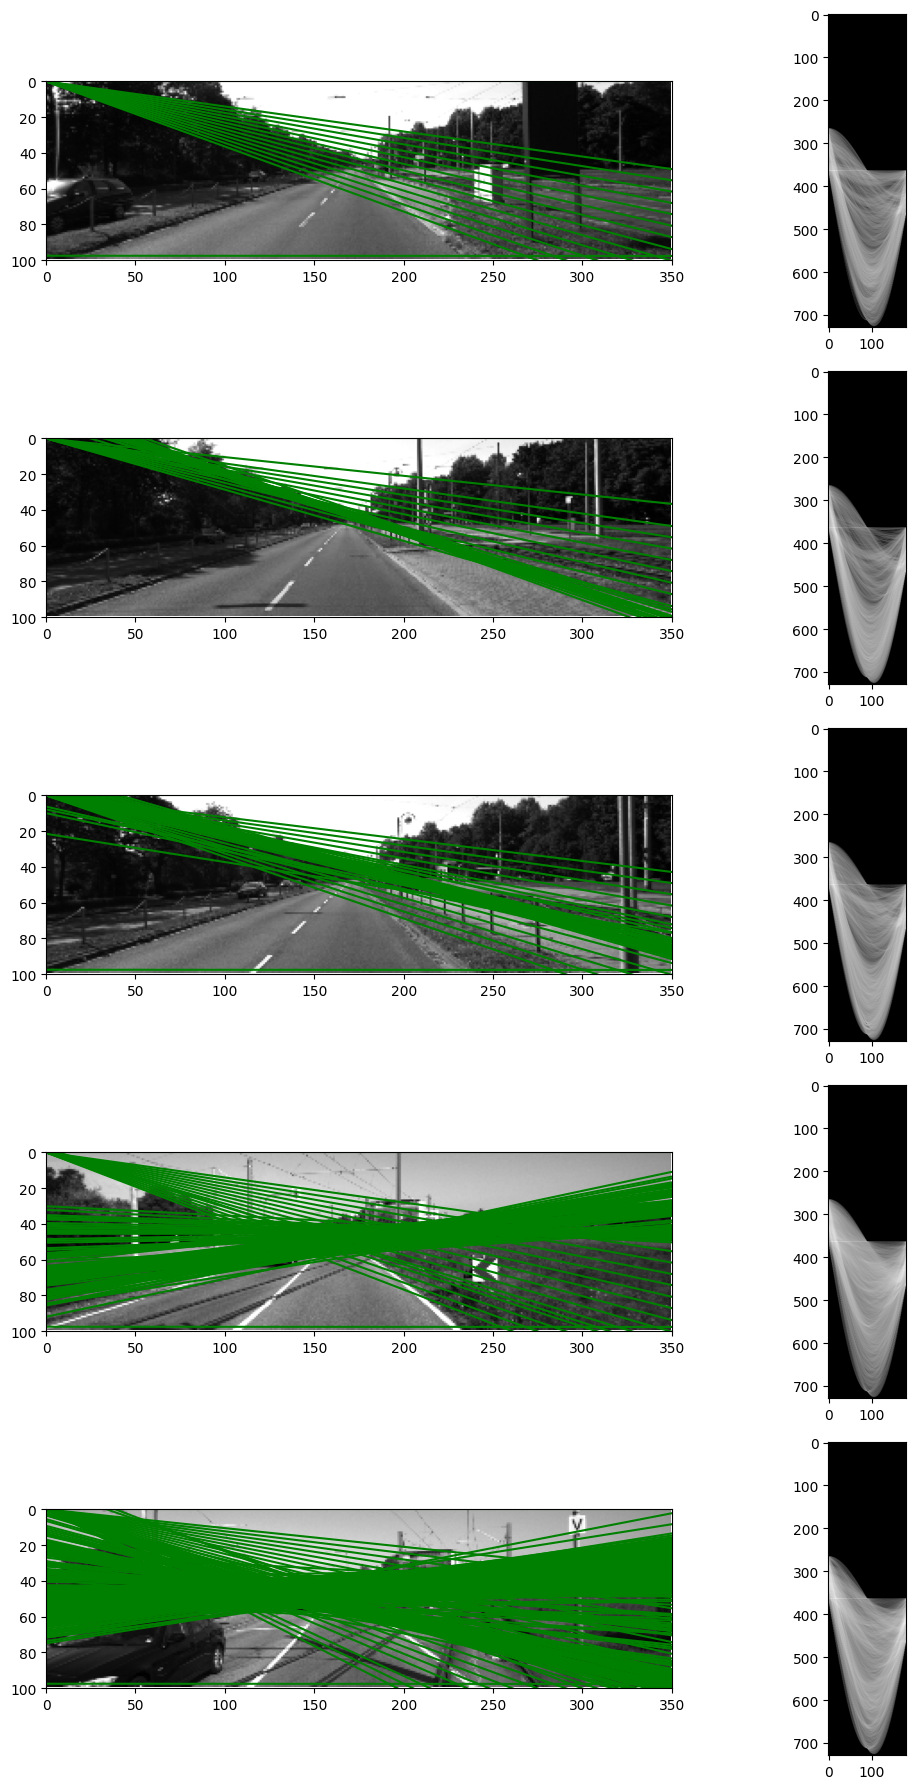

In [21]:
fig, ax = plt.subplots(5,2, figsize=(12, 18))
for i in range(5):
    # Abrir la imagen de entrada
    ruta = '../../IMAGES/DATASET_IMAGES/KITII/testing/um_00000' + str(i) + '.png'
    image = cv2.imread(ruta, 0)
    img = np.copy(image)
    wid, hght = img.shape

    # Suavizar la imagen con Gauss
    gaussian = suavizado(img)

    # Obtener sus derivadas
    sobel_x = convolucion(gaussian, kernel_sobel_x)
    sobel_y = convolucion(gaussian, kernel_sobel_y)

    # Aplicar Canny para detecccion de bordes
    img_canny = canny(img, 50, 60, sobel_x, sobel_y)

    # Redimensionar la imagen
    img_canny = cv2.resize(img_canny,(350, 100), interpolation = cv2.INTER_LINEAR)

    # Aplicar la transformada de Hough
    H, thetas, rhos = hough_transform(img_canny)
    rho_values, theta_values = hough_line_peaks(H, thetas, rhos)

    img = cv2.resize(img,(350, 100), interpolation = cv2.INTER_LINEAR)

    # Imprimir la deteccion de lineas
    ax[i,0].imshow(img, cmap='gray')
    for rho, theta in zip(rho_values, theta_values):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + (1500) * (-b))
        y1 = int(y0 + (1500) * (a))
        x2 = int(x0 - (1500) * (-b))
        y2 = int(y0 - (1500) * (a))
        ax[i,0].plot([x1, x2], [y1, y2], 'g')
        ax[i,0].set_xlim([0, img.shape[1]])
        ax[i,0].set_ylim([img.shape[0], 0])
    ax[i,1].imshow(np.log(1 + H), cmap='gray')
    
plt.tight_layout()
plt.show()

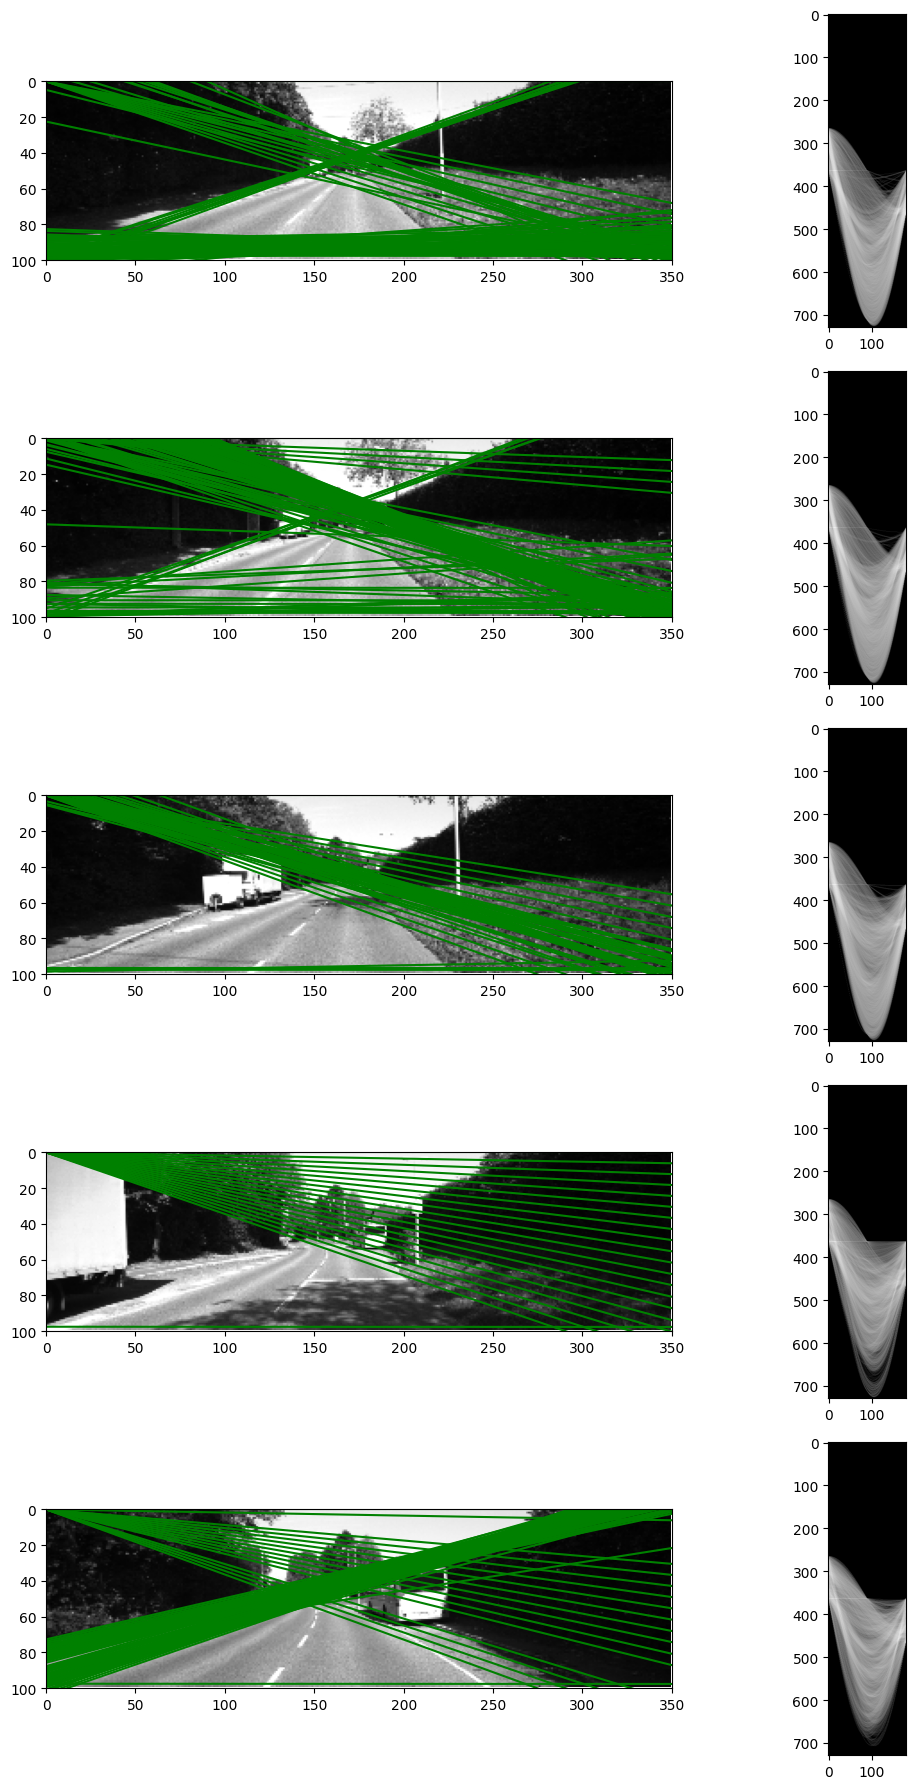

In [24]:
fig, ax = plt.subplots(5,2, figsize=(12, 18))
axis = 0
for i in range(20,25):
    ruta = '../../IMAGES/DATASET_IMAGES/KITII/testing/um_0000' + str(i) + '.png'
    image = cv2.imread(ruta, 0)
    img = np.copy(image)
    wid, hght = img.shape
    gaussian = suavizado(img)
    sobel_x = convolucion(gaussian, kernel_sobel_x)
    sobel_y = convolucion(gaussian, kernel_sobel_y)
    img_canny = canny(img, 50, 60, sobel_x, sobel_y)
    img_canny = cv2.resize(img_canny,(350, 100), interpolation = cv2.INTER_LINEAR)
    H, thetas, rhos = hough_transform(img_canny)
    rho_values, theta_values = hough_line_peaks(H, thetas, rhos)
    img_canny = cv2.resize(img,(350, 100), interpolation = cv2.INTER_LINEAR)
    img = cv2.resize(img,(350, 100), interpolation = cv2.INTER_LINEAR)
    ax[axis,0].imshow(img, cmap='gray')
    for rho, theta in zip(rho_values, theta_values):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + (1500) * (-b))
        y1 = int(y0 + (1500) * (a))
        x2 = int(x0 - (1500) * (-b))
        y2 = int(y0 - (1500) * (a))
        ax[axis,0].plot([x1, x2], [y1, y2], 'g')
        ax[axis,0].set_xlim([0, img.shape[1]])
        ax[axis,0].set_ylim([img.shape[0], 0])
    ax[axis,1].imshow(np.log(1 + H), cmap='gray')
    axis = axis + 1
plt.tight_layout()
plt.show()

# Algoritmo de etiquetado de componentes conectados

In [2]:
def bin (image2, rango):
    
    # Dice cual es el rango de valores
    plana=[x for y in image2 for x in y]
    #print(f"el valor máximo es: {max(plana)} y el mínimo es: {min(plana)}")

    # Modificando "rango" modificas el umbral
    #rango = -30
    umbral = ((min(plana) + max(plana))/2) + rango
    # print(umbral)

    # Binarizacion
    _, imgBin = cv2.threshold(image2, umbral, 255, cv2.THRESH_BINARY)
    
    #Bin inversa
    for i in np.nditer(imgBin, op_flags=['readwrite']):
        i[...] = 255 - i

    #Regresa binaria
    return imgBin

In [3]:
# Matriz de prueba parecida a la del ejercicio de clase
a = 255
b = 0
test = np.array([
        [a, a, b, b, a, a, a, a],
        [a, b, b, b, b, a, a, a],
        [b, a, a, a, b, b, a, a],
        [b, b, a, b, a, b, a, a],
        [b, a, a, a, a, a, b, b],
        [b, a, a, b, a, a, b, b],
        [b, a, b, b, b, a, b, b],
        [a, a, a, b, b, b, b, a]])

def pasada1 (foto):

    forma2 = np.shape(foto)
    base2 = np.zeros(forma2)
    base3 = np.zeros(forma2)

    alto, ancho = forma2

    # Primer valor
    grupo = 1

    # Llenado de valores
    for y2 in range(alto):
        for x2 in range(ancho):
            
            if foto[y2,x2] == 255: # Si el valor en la matriz es 255 (blanco)
                
                if base2[y2,x2-1] != 0: # Si el valor a la izquierda es diferente de 0, toma ese valor
                    base2[y2,x2] = base2[y2,x2-1]
                    #print("Padre: [",y2,"]","[",x2-1,"]  Valor:(",base2[y2,x2-1],") --> Hijo:[",y2,"]","[",x2,"]")
                
                if base2[y2-1,x2] != 0: # Si el valor arriba es diferente de 0, toma ese valor
                    base2[y2,x2] = base2[y2-1,x2]
                    #print("Padre: [",y2-1,"]","[",x2,"]  Valor:(",base2[y2-1,x2],") --> Hijo:[",y2,"]","[",x2,"]")
                
                # Si los valores tanto arriba como a la izquierda son diferentes de 0, elige el menor
                if (base2[y2,x2-1] != 0) and (base2[y2-1,x2] != 0):
                    
                    if(base2[y2,x2-1] < base2[y2-1,x2]): # Si el valor a la izquierda es menor, toma ese valor
                        base2[y2,x2] = base2[y2,x2-1]
                        #print("Padre: [",y2,"]","[",x2-1,"]  Valor:(",base2[y2,x2-1],") --> Hijo:[",y2,"]","[",x2,"]")
                    
                    else: # Caso opuesto (entonces el de arriba es menor)
                        base2[y2,x2] = base2[y2-1,x2]
                        #print("Padre: [",y2-1,"]","[",x2,"]  Valor:(",base2[y2-1,x2],") --> Hijo:[",y2,"]","[",x2,"]")
                
                # Si el valor es 0 (y no tiene vecinos, porque primero se ve si tiene vecinos (codigo de arriba)) entonces asigna el valor de grupo nuevo
                if base2[y2,x2] == 0:
                    base2[y2,x2] = grupo
                    grupo = grupo+1
    
    return base2

In [4]:
def pasada2(base2):

    # Dimensiones 
    forma2 = np.shape(base2)
    base3 = np.zeros(forma2)
    alto, ancho = forma2

    # Recorrer imagen anterior
    for y2 in range(alto):
        for x2 in range(ancho):
            
            # Lista donde se guardaran valores
            lista = []
            
            # Seleccion de elementos que no son 0
            if base2[y2,x2] != 0:
                
                # Ingresar el mismo valor de la posicion actual a la lista
                lista.append(base2[y2,x2])                
                    
                if(y2>0) and (base2[y2-1][x2] != 0):
                    #[^] Vecino de arriba:
                    lista.append(base2[y2-1][x2]) # Ingresar valor a la lista
                    
                if(x2<(ancho-1)) and (base2[y2][x2+1] != 0):
                    #[->] Vecino de la derecha
                    lista.append(base2[y2][x2+1]) # Ingresar valor a la lista
                
                if(y2<(alto-1)) and (base2[y2+1][x2] != 0):
                    #[v] Vecino de abajo
                    lista.append(base2[y2+1][x2]) # Ingresar valor a la lista
                    
                if(x2>0) and (base2[y2][x2-1] != 0):
                    #[<-] Vecino de la izquierda
                    lista.append(base2[y2][x2-1]) # Ingresar valor a la lista

                """
                # Imprimir posicion y lista de valores vecinos
                print("[",y2,"]","[",x2,"]",lista)
                
                #Imprimir vecino mas pequeño
                print("min ",min(lista))
                
                """
                # Asignacion de valor mas pequeño de la lista
                base3[y2,x2] = min(lista)

    return base3

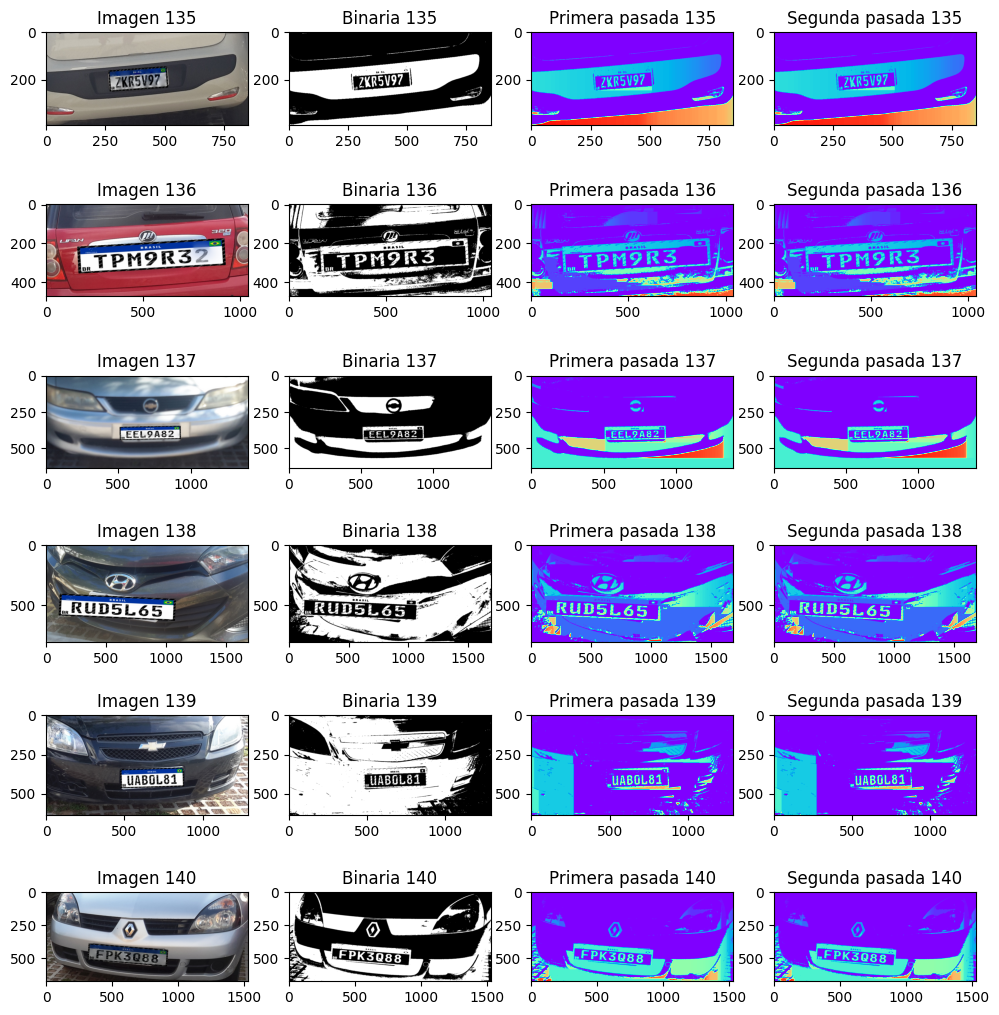

In [6]:
# Mostrar resultados
fig, ax = plt.subplots(6,4, figsize=(12, 13))
axis = 0

for i in range(135,141):
    
    #Imagen de entrada
    ruta = '../../IMAGES/DATASET_IMAGES/ArtificialMercosurLicensePlates/cropped_parking_lot_'
    image2 = cv2.imread(ruta + '%03d.jpg' %i, 0)
    
    #Original
    BRG = cv2.imread(ruta + '%03d.jpg' %i, 1)
    imagen_rgb = cv2.cvtColor(BRG, cv2.COLOR_BGR2RGB)
    ax[axis,0].set_title('Imagen ' + '%03d' %i)
    ax[axis,0].imshow(imagen_rgb)
    
    #Binaria
    foto = bin(image2, -40)
    ax[axis,1].set_title('Binaria ' + '%03d' %i)
    ax[axis,1].imshow(foto,cmap='gray')
    
    #Pasada1
    foto2 = pasada1(foto)
    ax[axis,2].set_title('Primera pasada '+ '%03d' %i)
    ax[axis,2].imshow(foto2,cmap='rainbow')
    
    #Pasada2
    foto3 = pasada2(foto2)
    ax[axis,3].set_title('Segunda pasada '+ '%03d' %i)
    ax[axis,3].imshow(foto3,cmap='rainbow')
    
    axis = axis+1   
    